Import libraries

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error,log_loss
from tqdm import tqdm
import time
import imageio
import seaborn as sns
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [50]:
from tqdm import tqdm_notebook

In [26]:
my_cmap=matplotlib.colors.LinearSegmentedColormap.from_list("",["red","blue","green","black"])

In [27]:
np.random.seed(0)

In [28]:
data,labels=make_blobs(n_samples=1000,centers=4,n_features=2,random_state=0)
print(data.shape,labels.shape)

(1000, 2) (1000,)


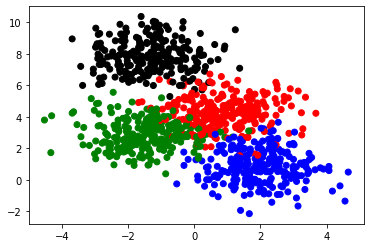

In [29]:
plt.scatter(data[:,0],data[:,1],c=labels,cmap=my_cmap)
plt.show()

In [30]:
labels_changed=np.mod(labels,2)
print(labels[:5])
print(labels_changed[:5])

[3 0 3 2 1]
[1 0 1 0 1]


In [31]:
X_train,X_val,Y_train,Y_val=train_test_split(data,labels,stratify=labels,random_state=0)
print(X_train.shape,Y_val.shape)

(750, 2) (250,)


In [32]:
enc=OneHotEncoder()
y_enc_train=enc.fit_transform(Y_train.reshape(-1,1)).toarray()
y_enc_val=enc.fit_transform(Y_val.reshape(-1,1)).toarray()
print(y_enc_train.shape,y_enc_val.shape)
print(y_enc_train[:5])
print(Y_train[:5])

(750, 4) (250, 4)
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
[0 3 3 2 2]


In [94]:
class FNN:
    def __init__(self,init_method="random",activation="sigmoid",leaky_slope=0.1):
        
        self.params={}
        self.params_h=[]
        self.num_layers=2
        self.layer_size=[2,2,4]
        self.activation_function=activation
        self.leaky_slope=leaky_slope
        
        np.random.seed(0)
        
        if init_method=="random":
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.random.randn(self.layer_size[i-1],self.layer_size[i])
                self.params["B"+str(i)]=np.random.randn(1,self.layer_size[i])
        
        elif init_method=="he":
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.random.randn(self.layer_size[i-1],self.layer_size[i])*(np.sqrt(2)/np.sqrt(self.layer_size[i-1]))
                self.params["B"+str(i)]=np.random.randn(1,self.layer_size[i])

        elif init_method=="xavier":
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.random.randn(self.layer_size[i-1],self.layer_size[i])*(1.0/np.sqrt(self.layer_size[i-1]))
                self.params["B"+str(i)]=np.random.randn(1,self.layer_size[i])
        
        elif init_method == "zeros":
            for i in range(1,self.num_layers+1):
                self.params["W"+str(i)]=np.zeros((self.layer_size[i-1],self.layer_size[i]))
                self.params["B"+str(i)]=np.zeros((1,self.layer_size[i]))
        
        self.gradients={}
        self.update_params={}
        self.prev_update_params={}
        for i in range(1,self.num_layers+1):
            self.update_params["v_w"+str(i)]=0
            self.update_params["v_b"+str(i)]=0
            self.update_params["m_b"+str(i)]=0
            self.update_params["m_w"+str(i)]=0
            self.prev_update_params["v_w"+str(i)]=0
            self.prev_update_params["v_b"+str(i)]=0
        
    def forward_activation(self,X):
        if(self.activation_function=="sigmoid"):
            return 1.0/(1.0+np.exp(-X))
        elif(self.activation_function=="tanh"):
            return np.tanh(X)
        elif(self.activation_function=="relu"):
            return np.maximum(0,X)
        elif(self.activation_function=="leaky_relu"):
            return np.maximum(self.leaky_slope*X,X)
    
    def grad_activation(self,X):
        if self.activation_function == "sigmoid":
            return X*(1-X)
        elif self.activation_function == "tanh":
            return 1-np.square(X)
        elif self.activation_function == "relu":
            return 1*(X>0)
        elif self.activation_function == "leaky_relu":
            d=np.zeros_like(X)
            d[X<=0]=self.leaky_slope
            d[X>0]=1
            return d
    
    def softmax(self,X):
        exps=np.exp(X)
        return exps/np.sum(exps,axis=1).reshape(-1,1)
            
    
    def forward_pass(self,X,params):
        if params is None:
            params=self.params
        self.A1=np.matmul(X,params["W1"])+params["B1"]
        self.H1=self.forward_activation(self.A1)
        self.A2=np.matmul(X,params["W2"])+params["B2"]
        self.H2=self.forward_activation(self.A2)
        return self.H2
    
    def grad(self,X,Y,params=None):
        if params is None:
            params=self.params
        self.forward_pass(X,params)
        m=X.shape[0]
        self.gradients["dA2"]=self.H2-Y
        self.gradients["dW2"]=np.matmul(self.H1.T,self.gradients["dA2"])
        self.gradients["dB2"]=np.sum(self.gradients["dA2"],axis=0).reshape(1,-1)
        self.gradients["dH1"]=np.matmul(self.gradients["dA2"],self.params["W2"].T)
        self.gradients["dA1"]=np.multiply(self.gradients["dH1"],self.grad_activation(self.H1))
        self.gradients["dW1"]=np.matmul(X.T,self.gradients["dA1"])
        self.gradients["dB1"]=np.sum(self.gradients["dA1"],axis=0).reshape(1,-1)
    

    def fit(self,X,Y,epochs=1,eta=1,algo="GD",display_loss=True):
        
        if display_loss:
            loss={}
            Y_pred=self.predict(X)
            loss[0]=log_loss(np.argmax(Y,axis=1),Y_pred)
        
        for num_epoch in tqdm_notebook(range(epochs),total=epochs,unit="epoch"):
            m=X.shape[0]
            
            if algo=="GD":
                self.grad(X,Y)
                for i in range(1,self.num_layers+1):
                    self.params["W"+str(i)]-=eta*(self.gradients["dW"+str(i)]/m)
                    self.params["B"+str(i)]-=eta*(self.gradients["dB"+str(i)]/m)
            
            elif algo=="MiniBatch":
                for k in range(0,m,mini_batch_size):
                    self.grad(X[k:k+mini_batch_size],Y[k:k+mini_batch_size])
                    for i in range(1,self.num_layers+1):
                        self.params["W"+str(i)]-=eta*(self.gradients["dW"+str(i)]/m)
                        self.params["B"+str(i)]-=eta*(self.gradients["dB"+str(i)]/m)
            
            elif algo=="Adam":
                beta1=0.9
                beta2=0.8
                eps=0.1
                self.grad(X,Y)
                num_updates=0
                for i in range(1,self.num_layers+1):
                    num_updates+=1
                    self.update_params["m_w"+str(i)]=beta1*self.update_params["m_w"+str(i)]+(1-beta1)*(self.gradients["dW"+str(i)])
                    self.update_params["v_w"+str(i)]=beta2*self.update_params["v_w"+str(i)]+(1-beta2)*np.square(self.gradients["dW"+str(i)])
                    m_w_hat=self.update_params["m_w"+str(i)]/(1-np.power(beta1,num_updates))
                    v_w_hat=self.update_params["v_w"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["W"+str(i)]-=(eta/(np.sqrt(v_w_hat)+eps))*m_w_hat
                    
                    self.update_params["m_b"+str(i)]=beta1*self.update_params["m_b"+str(i)]+(1-beta1)*self.gradients["dB"+str(i)]
                    self.update_params["v_b"+str(i)]=beta2*self.update_params["v_b"+str(i)]+(1-beta2)*np.square(self.gradients["dB"+str(i)])
                    m_b_hat=self.update_params["m_b"+str(i)]/(1-np.power(beta1,num_updates))
                    v_b_hat=self.update_params["v_b"+str(i)]/(1-np.power(beta2,num_updates))
                    self.params["B"+str(i)]-=(eta/(np.sqrt(v_b_hat)+eps))*m_b_hat
                    
            if display_loss:
                Y_pred=self.predict(X)
                loss[num_epoch+1]=log_loss(np.argmax(Y,axis=1),Y_pred)
                #self.params_h.append(np.concatenate((self.params["W1"].ravel(),self.params["W2"].ravel().self.params["B1"].ravel(),self.params["B2"].ravel())))
        
        if display_loss:
            plt.plot(np.array(list(loss.values())).astype("float"),"-o",markersize=5)
            plt.xlabel("Epochs")
            plt.plot("Log_loss")
            plt.show()
    
    def predict(self,X):
        Y_pred=self.forward_pass(X,None)
        return np.array(Y_pred).squeeze()


        
            
    
                
            
            
            
        

In [72]:
def post_process(scatter_plot=True,gradient_plot=False,plot_scale=0.1):
    Y_pred_train=model.predict(X_train)
    Y_pred_train=np.argmax(Y_pred_train,1)
    Y_pred_val=model.predict(X_val)
    Y_pred_val=np.argmax(Y_pred_val,1)
    accuracy_train=accuracy_score(Y_pred_train,Y_train)
    accuracy_val=accuracy_score(Y_pred_val,Y_val)
    print("Training accuracy : ",round(accuracy_train,4))
    print("Validation accuracy : ",round(accuracy_val,4))
    
    if scatter_plot :
        plt.scatter(X_train[:,0],X_train[:,1],c=Y_pred_train,cmap=my_cmap,s=15*(np.abs(np.sign(Y_pred_train-Y_train))))
        plt.show()
    

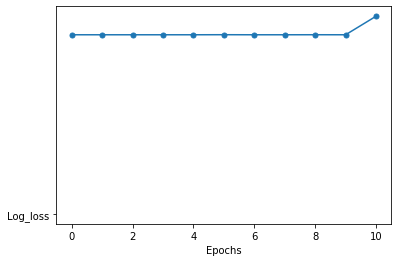

Training accuracy :  0.2507
Validation accuracy :  0.248


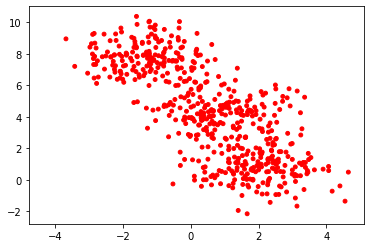

In [98]:
model=FNN(init_method="zeros",activation="leaky_relu")
model.fit(X_train,y_enc_train,epochs=10,eta=1,algo="Adam",display_loss=True)
post_process()